# <b><u>False Positive Analysis and Cleaning<b><u>

This script offers a cleaning approach for falsly predicted crop pixels using a Random Forest Model which is trained on labeled training data.

### Load necessary packages

In [1]:
# Standard library imports
import math
import os
import random
import shutil
import tempfile
from collections import defaultdict
from math import ceil

# Third-party imports
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from osgeo import gdal, gdalconst, osr
from rasterio.windows import Window
from scipy.stats import randint, uniform
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import joblib
import seaborn as sns

# **Section 1: Reclassify Rasters and create Sampling Points**

#### Step 1: Reclassify Predicted Fractional Map to low frequency and high frequency crop field 

In [ ]:
# Input merged Raster
input_path = r"C:\Users\phili\Thesis\tmp\ValidatedTiles\merged_fractional_map.tif"

In [ ]:
output_dir = r"C:\Users\phili\Thesis\tmp\false_positive_analysis\FP_Raster_output"
os.makedirs(output_dir, exist_ok=True)  # Create directory if missing
output_path = os.path.join(output_dir, "crop_frequency_reclass.tif")

In [ ]:
# Open input raster
src_ds = gdal.Open(input_path)
band = src_ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

# Create output raster with same dimensions and projection
driver = gdal.GetDriverByName('GTiff')
dst_ds = driver.Create(
    output_path, xsize, ysize, 1, gdal.GDT_Byte,
    options=['COMPRESS=LZW', 'BIGTIFF=YES']
)
dst_ds.SetProjection(src_ds.GetProjection())
dst_ds.SetGeoTransform(src_ds.GetGeoTransform())
out_band = dst_ds.GetRasterBand(1)
out_band.SetNoDataValue(0)

# Optimize block size based on raster structure
block_sizes = band.GetBlockSize()
x_block_size = block_sizes[0]
y_block_size = block_sizes[1]

# Process raster in blocks
for y in range(0, ysize, y_block_size):
    if y + y_block_size < ysize:
        rows = y_block_size
    else:
        rows = ysize - y
        
    for x in range(0, xsize, x_block_size):
        if x + x_block_size < xsize:
            cols = x_block_size
        else:
            cols = xsize - x

        # Read block
        data = band.ReadAsArray(x, y, cols, rows)
        
        # Reclassify using vectorized operations
        reclassified = np.full(data.shape, 0, dtype=np.uint8)  # Initialize with NoData
        mask_low = (data > 0) & (data <= 50)
        mask_high = data > 50
        reclassified[mask_low] = 1
        reclassified[mask_high] = 2
        
        # Write block
        out_band.WriteArray(reclassified, x, y)

# Finalize output
dst_ds.FlushCache()
dst_ds = None
src_ds = None

### Step 2: Reclassify Land Cover Crop Raster to 3 classes: 0 (all agree non-crop), 1 (1-2 agree it's crop), 2 (3-4 agree it's crop)

In [ ]:
input_path = r"C:\Users\phili\Thesis\tmp\no_crop_mask\non_crop_mask_final.tif"
output_dir = r"C:\Users\phili\Thesis\tmp\false_positive_analysis\FP_Raster_output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "landcover_crop_reclass.tif")

In [ ]:

with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    profile.update(
        dtype='uint8',
        nodata=255,
        compress='lzw'
    )
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        # Process raster in 512x512 blocks
        for ji, window in src.block_windows(1):
            data = src.read(1, window=window)
            
            # Initialize output with NoData (255)
            reclassified = np.full_like(data, 255, dtype='uint8')
            
            # Exact value reclassification
            reclassified[data == 100] = 0    # Class 0
            reclassified[data == 75] = 1     # Class 1
            reclassified[data == 50] = 1     # Class 1
            reclassified[data == 25] = 2     # Class 2
            reclassified[data == 0] = 2      # Class 2
            
            dst.write(reclassified, window=window, indexes=1)

### Step 3: Intersect both Maps

In [ ]:
# Input paths
crop_freq_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/crop_frequency_reclass.tif"
lc_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/landcover_crop_reclass.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"

In [ ]:
# Configure GDAL for massive datasets
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN', 'YES')
gdal.SetConfigOption('CHECK_DISK_FREE_SPACE', 'NO')
gdal.SetConfigOption('GDAL_NUM_THREADS', 'ALL_CPUS')

# Open datasets
crop_ds = gdal.OpenEx(crop_freq_path, gdalconst.GA_ReadOnly)
lc_ds = gdal.OpenEx(lc_path, gdalconst.GA_ReadOnly)

# Get crop raster parameters
crop_gt = crop_ds.GetGeoTransform()
crop_proj = crop_ds.GetProjection()
cols = crop_ds.RasterXSize
rows = crop_ds.RasterYSize

# Create output with compression
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(
    output_path, cols, rows, 1, gdalconst.GDT_Byte,
    options=['COMPRESS=LZW', 'PREDICTOR=2', 'TILED=YES', 'BIGTIFF=YES', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256']
)
output_ds.SetGeoTransform(crop_gt)
output_ds.SetProjection(crop_proj)
output_band = output_ds.GetRasterBand(1)
output_band.SetNoDataValue(0)

# Process in blocks with exact dimension matching
block_size = 1024  # Keep this as-is
total_blocks = ((rows + block_size - 1) // block_size) * ((cols + block_size - 1) // block_size)

with tqdm(total=total_blocks, desc="Processing", unit="block") as pbar:
    for y_offset in range(0, rows, block_size):
        y_height = min(block_size, rows - y_offset)
        
        for x_offset in range(0, cols, block_size):
            x_width = min(block_size, cols - x_offset)
            
            # Read crop frequency block
            crop_block = crop_ds.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_width, y_height)
            
            # Calculate exact bounds for this block
            x_min = crop_gt[0] + x_offset * crop_gt[1]
            y_max = crop_gt[3] + y_offset * crop_gt[5]
            x_max = x_min + x_width * crop_gt[1]
            y_min = y_max + y_height * crop_gt[5]
            
            # Warp LC data with EXPLICIT output dimensions
            lc_block = gdal.Warp('', lc_path,
                format='MEM',
                outputBounds=(x_min, y_min, x_max, y_max),
                xRes=crop_gt[1],
                yRes=abs(crop_gt[5]),
                width=x_width,  # Force exact dimension match
                height=y_height,
                resampleAlg=gdalconst.GRA_NearestNeighbour,
                outputType=gdalconst.GDT_Byte
            ).ReadAsArray()
            
            # Verify block shapes match
            if crop_block.shape != lc_block.shape:
                raise ValueError(f"Block shape mismatch at ({x_offset},{y_offset}): {crop_block.shape} vs {lc_block.shape}")
            
            # Calculate output classes
            output_data = np.zeros_like(crop_block, dtype=np.uint8)
            
            # Class mapping with explicit casting
            output_data = output_data.astype(np.uint8)
            output_data[(crop_block == 1) & (lc_block == 0)] = 1
            output_data[(crop_block == 1) & (lc_block == 1)] = 2
            output_data[(crop_block == 1) & (lc_block == 2)] = 3
            output_data[(crop_block == 2) & (lc_block == 0)] = 4
            output_data[(crop_block == 2) & (lc_block == 1)] = 5
            output_data[(crop_block == 2) & (lc_block == 2)] = 6
            
            # Write output with exact window
            output_band.WriteArray(output_data, xoff=x_offset, yoff=y_offset)
            pbar.update(1)

# Cleanup
output_ds = None
crop_ds = None
lc_ds = None

print(f"✅ Success! Output created at: {output_path}")

### Step 4: Sample Points within each class

#### 4.1: Count Pixels per Class

In [ ]:
raster_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points.gpkg"

In [ ]:
def count_classes_blocked(raster_path):
    """Count pixels per class with progress tracking"""
    ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    xsize, ysize = band.XSize, band.YSize
    block_x, block_y = band.GetBlockSize()
    
    counts = {}
    total_blocks = ((ysize + block_y - 1) // block_y) * ((xsize + block_x - 1) // block_x)
    
    with tqdm(total=total_blocks, desc="Counting classes", unit="block") as pbar:
        for y in range(0, ysize, block_y):
            y_height = min(block_y, ysize - y)
            for x in range(0, xsize, block_x):
                x_width = min(block_x, xsize - x)
                data = band.ReadAsArray(x, y, x_width, y_height)
                
                if nodata is not None:
                    data = data[data != nodata]
                
                unique, counts_chunk = np.unique(data, return_counts=True)
                for val, cnt in zip(unique, counts_chunk):
                    if val == 0:  # Skip NoData
                        continue
                    counts[val] = counts.get(val, 0) + int(cnt)
                
                pbar.update(1)
    
    ds = None
    return counts

In [ ]:
# Count classes
class_counts = count_classes_blocked(intersect_raster)
print("Pixel counts per class:", class_counts)

In [ ]:
# Use pre-calculated pixel counts
pixel_counts = {3: 431784025, 1: 15857486835, 4: 6093596578, 
                5: 3622280348, 2: 3342416411, 6: 1171686069}
total_pixels = sum(pixel_counts.values())

# Calculate proportional samples
samples_per_class = {
    cls: max(1, ceil((count / total_pixels) * 300)) 
    for cls, count in pixel_counts.items()
}

In [ ]:
def calculate_samples(pixel_counts, total_samples=300):
    total = sum(pixel_counts.values())
    samples = {
        cls: max(1, int(round((count / total) * total_samples)))
        for cls, count in pixel_counts.items()
    }
    # Adjust to exact total
    current_total = sum(samples.values())
    if current_total != total_samples:
        adjust_cls = max(samples, key=lambda k: samples[k])
        samples[adjust_cls] += (total_samples - current_total)
    return samples

def random_pixel_sampling(raster_path, samples_per_class, max_attempts=1000000, min_distance_deg=0.001):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        classes_needed = samples_per_class.copy()
        found_points = defaultdict(list)
        found_coords = []

        total_needed = sum(classes_needed.values())
        attempts = 0

        # For progress bar
        pbar = tqdm(total=total_needed, desc="Random sampling", unit="pt")

        while sum(classes_needed.values()) > 0 and attempts < max_attempts:
            # Random pixel
            row = random.randint(0, height - 1)
            col = random.randint(0, width - 1)
            val = src.read(1, window=rasterio.windows.Window(col, row, 1, 1))[0, 0]

            # Only sample if this class still needs points
            if val in classes_needed and classes_needed[val] > 0:
                # Convert to lon/lat
                lon, lat = src.xy(row, col)
                pt = Point(lon, lat)

                # Check minimum distance constraint
                too_close = False
                for other_pt in found_coords:
                    if pt.distance(other_pt) < min_distance_deg:
                        too_close = True
                        break
                if too_close:
                    attempts += 1
                    continue

                found_points[val].append(pt)
                found_coords.append(pt)
                classes_needed[val] -= 1
                pbar.update(1)
            attempts += 1

        pbar.close()

        # Flatten to GeoDataFrame
        data = []
        for cls, pts in found_points.items():
            for pt in pts:
                data.append({'class': cls, 'geometry': pt})
        gdf = gpd.GeoDataFrame(data, crs='EPSG:4326')

        if sum(classes_needed.values()) > 0:
            print(f"Warning: Could not find all samples. Missing: {classes_needed}")

        return gdf

In [ ]:

def main():
    samples = calculate_samples(pixel_counts)
    print("Samples per class:", samples)
    gdf = random_pixel_sampling(raster_path, samples, min_distance_deg=0.001)  # ~100m at equator
    gdf.to_file(output_path, driver="GPKG")
    print(f"Saved {len(gdf)} points to {output_path}")

if __name__ == "__main__":
    main()

<br>

---

<br>

# **Section 2: Sampling in Google Earth Engine**

### Connect to GEE

In [6]:
ee.Authenticate()
# Initialize the Earth Engine API and Project
ee.Initialize(project='angola-thesis')

In [7]:
# Load sampling points 
points = ee.FeatureCollection('projects/angola-thesis/assets/sampling_points_labeled')

# Load Angola boundary 
angola = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_dissolve')

# Check if assets exist
print(points.size().getInfo())  # Should return 300
print(angola.size().getInfo())  # Should return 1 

300
1


## Load Predictor Variables

#### DEM

In [8]:
# ALOS DSM (12m)
alos = ee.ImageCollection('JAXA/ALOS/AW3D30/V3_2') \
         .mosaic() \
         .select('DSM') \
         .clip(angola)

# Terrain derivatives
slope = ee.Terrain.slope(alos).rename('slope')
tpi = alos.subtract(alos.reduceNeighborhood(
    reducer=ee.Reducer.mean(),
    kernel=ee.Kernel.square(3)
)).rename('tpi')

#### Soil Texture

In [9]:
# Soil Texture (250m)
soil = ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02') \
    .select('b0').rename('soil_texture')

# ESA WorldCover (10m)
landcover = ee.ImageCollection('ESA/WorldCover/v200') \
    .filterDate('2020-01-01', '2024-12-31') \
    .first()

#### Evapotranspiration + Precipitation

In [10]:
# MODIS Evapotranspiration (500m)
et = ee.ImageCollection('MODIS/061/MOD16A2') \
    .filterDate('2018-01-01', '2023-12-31') \
    .select('ET') \
    .mean() \
    .multiply(0.1)  # Scale factor
# Ends 2023

# CHIRPS Precipitation (5km)
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('2018-01-01', '2024-12-31') \
    .sum()

# Compute Aridity Index (Precipitation/ET)
aridity = precip.divide(et).rename('aridity')

#### MODIS Temporal Vegetation Features

In [11]:
# MODIS Temporal Features (Phenology)
modis_temp = ee.ImageCollection("MODIS/061/MCD12Q2") \
    .filterDate('2018-01-01', '2023-12-31') \
    .select(['Greenup_1', 'Peak_1', 'QA_Overall_1']) \
    .map(lambda img: img.updateMask(img.select('QA_Overall_1').eq(0))) \
    .mean() \
    .resample('bilinear').reproject(crs='EPSG:4326', scale=500)

In [12]:
def create_modis_ndvi():
    modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
        .filterBounds(angola) \
        .filterDate('2018-01-01', '2024-12-31') \
        .select('NDVI')
    ndvi_mean = modis.mean().multiply(0.0001).rename('modis_ndvi_mean')
    ndvi_std = modis.reduce(ee.Reducer.stdDev()).multiply(0.0001).rename('modis_ndvi_std')
    return ndvi_mean.addBands(ndvi_std)
modis_ndvi = create_modis_ndvi()

#### S2 NDVI

In [13]:
def create_lightweight_ndvi():
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(angola) \
        .filterDate('2024-01-01', '2024-12-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    ndvi = s2.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('ndvi')).median().rename('ndvi_2024')
    return ndvi

annual_ndvi_2024 = create_lightweight_ndvi()

In [14]:
def create_seasonal_ndvi():
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(angola) \
        .filterDate('2024-04-01', '2024-09-30') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    ndvi = s2.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('ndvi')).median().rename('ndvi_2024_season')
    return ndvi

seasonal_ndvi_2024 = create_seasonal_ndvi()

In [15]:
# Combine into single NDVI image
ndvi_features = annual_ndvi_2024 \
    .addBands(seasonal_ndvi_2024) \
    .addBands(modis_ndvi)

### Stack all Layers

In [16]:
# --- Helper functions ---
def prep_continuous(img):
    return img.resample('bilinear').reproject(crs='EPSG:32733', scale=10)

def prep_categorical(img):
    return img.reproject(crs='EPSG:32733', scale=10)  # Nearest neighbor by default

# --- Prepare high-res (10m) bands ---
ndvi_2024 = prep_continuous(ndvi_features.select('ndvi_2024'))
ndvi_2024_season = prep_continuous(ndvi_features.select('ndvi_2024_season'))
elevation = prep_continuous(alos.rename('elevation'))
slope_r = prep_continuous(slope)
tpi_r = prep_continuous(tpi)
landcover_r = prep_categorical(landcover.rename('landcover'))


# --- Prepare med-res (250m, upsample to 10m) ---
modis_ndvi_mean = prep_continuous(ndvi_features.select('modis_ndvi_mean'))
modis_ndvi_std = prep_continuous(ndvi_features.select('modis_ndvi_std'))
soil_texture_r = prep_categorical(soil.rename('soil_texture'))
et_r = prep_continuous(et)
aridity_r = prep_continuous(aridity)

# --- Prepare low-res (5km, upsample to 10m) ---
precip_r = prep_continuous(precip.rename('precip'))

# --- Stack all bands together ---
full_stack_10m = ndvi_2024 \
    .addBands(ndvi_2024_season) \
    .addBands(elevation) \
    .addBands(slope_r) \
    .addBands(tpi_r) \
    .addBands(landcover_r) \
    .addBands(modis_ndvi_mean) \
    .addBands(modis_ndvi_std) \
    .addBands(soil_texture_r) \
    .addBands(et_r) \
    .addBands(aridity_r) \
    .addBands(precip_r)

# --- Verify all bands are at 10m ---
band_names = full_stack_10m.bandNames().getInfo()
print('Bands in full_stack_10m:', band_names)
for band in band_names:
    scale = full_stack_10m.select(band).projection().nominalScale().getInfo()
    print(f'{band}: {scale} meters')

Bands in full_stack_10m: ['ndvi_2024', 'ndvi_2024_season', 'elevation', 'slope', 'tpi', 'landcover', 'modis_ndvi_mean', 'modis_ndvi_std', 'soil_texture', 'ET', 'aridity', 'precip']
ndvi_2024: 10 meters
ndvi_2024_season: 10 meters
elevation: 10 meters
slope: 10 meters
tpi: 10 meters
landcover: 10 meters
modis_ndvi_mean: 10 meters
modis_ndvi_std: 10 meters
soil_texture: 10 meters
ET: 10 meters
aridity: 10 meters
precip: 10 meters


### Extract values based on sampling points

In [81]:
def optimized_extraction(points):
    # Extract ALL bands at 10m resolution in one step
    extracted_data = full_stack_10m.select([
        'ndvi_2024', 'ndvi_2024_season',
        'elevation', 'slope', 'tpi', 'landcover',
        'modis_ndvi_mean', 'modis_ndvi_std',
        'soil_texture', 'ET', 'aridity', 'precip'
    ]).reduceRegions(
        collection=points,
        reducer=ee.Reducer.first(),
        scale=10  # Single scale for all bands
    )
    return extracted_data

# Usage remains the same
training_data = optimized_extraction(points)

In [82]:
# Export & Clean DataFrame
df = geemap.ee_to_df(training_data).dropna()

# Remove system columns
df = df[df.columns[~df.columns.str.startswith('system:')]]

# Verify columns
print(df.columns.tolist())

['ET', 'aridity', 'class', 'elevation', 'fid', 'field', 'landcover', 'modis_ndvi_mean', 'modis_ndvi_std', 'ndvi_2024', 'ndvi_2024_season', 'precip', 'slope', 'soil_texture', 'tpi']


In [83]:
print(len(df))


294


In [84]:
df.head()

,ET,aridity,class,elevation,fid,field,landcover,modis_ndvi_mean,modis_ndvi_std,ndvi_2024,ndvi_2024_season,precip,slope,soil_texture,tpi
0,15.819245,431.470581,1,1596,1,0,30,0.580881,0.101225,0.360424,0.355689,6789.705566,0.087670,9,397.789612
1,18.950357,461.125519,1,1128,2,0,30,0.612091,0.091663,0.562645,0.559514,8677.147461,0.046646,6,-38.275917
2,13.188731,199.603119,1,137,3,0,20,0.432457,0.120278,0.313387,0.311231,2631.131592,0.385973,6,-747.220032
3,13.192242,522.936401,1,1448,4,0,20,0.506669,0.110442,0.349949,0.352899,6891.132324,0.161254,9,398.354736
4,17.825676,342.983917,1,1370,6,0,30,0.622564,0.086424,0.566559,0.554272,6114.166016,0.033309,9,131.096237


### _Optional_: Build the RF Model in Python

In [85]:
# X: all predictor columns (drop identifiers and label)
x = df.drop(['fid', 'field', 'ndvi_2024_season', 'soil_texture', 'ndvi_2024', 'modis_ndvi_std', 'modis_ndvi_mean' ], axis=1)

# y: label (1 = field, 0 = non-field)
y = df['field']

In [86]:
# Impute missing values with column medians
imputer = SimpleImputer(strategy='median')
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

In [87]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.3,       # 30% for testing
    stratify=y,          # preserve class balance
    random_state=42
)

In [106]:
rf = RandomForestClassifier(
    n_estimators=256,        # Number of trees
    max_depth=29,            # Limit tree depth to prevent overfitting
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    max_features='log2',
    min_samples_split=10,
)
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=29,
                       max_features='log2', min_samples_split=10,
                       n_estimators=256, random_state=42)

Accuracy: 0.87
              precision    recall  f1-score   support

   Non-field       0.91      0.88      0.90        60
       Field       0.77      0.83      0.80        29

    accuracy                           0.87        89
   macro avg       0.84      0.86      0.85        89
weighted avg       0.87      0.87      0.87        89



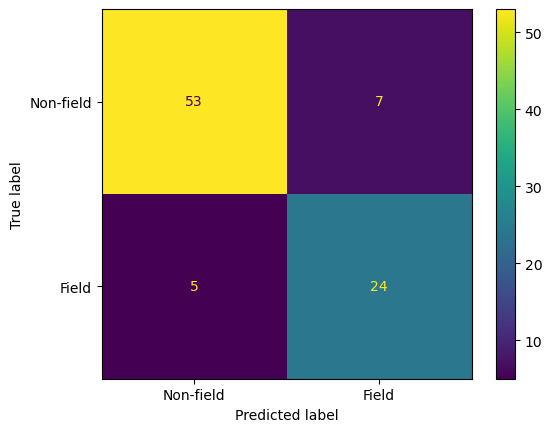

In [107]:
y_pred = rf.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=['Non-field', 'Field']))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Non-field', 'Field']).plot()

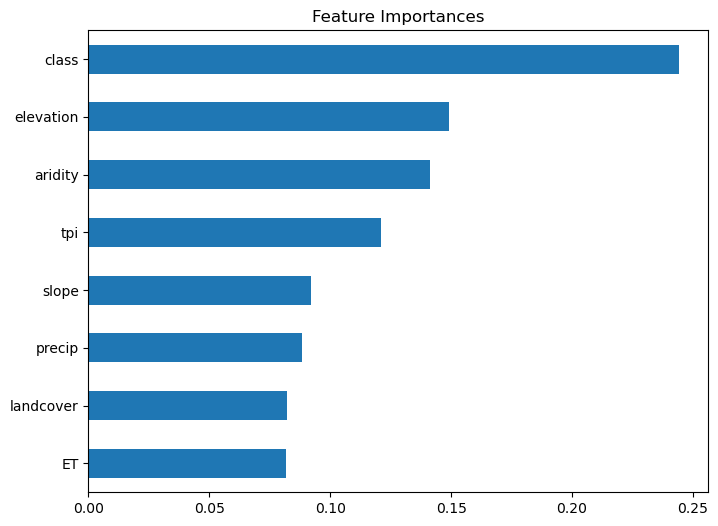

In [108]:
importances = pd.Series(rf.feature_importances_, index=x.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6), title='Feature Importances')
plt.show()

In [109]:
#Save RF Model
joblib.dump(rf, './RF_Model/field_detection_rf_model_04.joblib')  # Saves: model + metadat

['./RF_Model/field_detection_rf_model_04.joblib']

#### Hyperparameter Tuning

In [103]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample']
}

rand_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Increased from 10
    cv=5,
    scoring='roc_auc',
    random_state=42
)
rand_search.fit(x_train, y_train)

print('Best hyperparameters:', rand_search.best_params_)
best_rf = rand_search.best_estimator_

Best hyperparameters: {'class_weight': 'balanced_subsample', 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 256}


<br>

---

<br>

# **Section 3: Extract Predictors for Entire Study Area based on Tiles in GEE**

### Load Tiles in GEE

In [17]:
# Load Angola Tiles
tiles = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_non_overlap_crop_filtered')

# Check if assets exist
print(tiles.size().getInfo()) 

36496


### Add 'Class' Attribute from Sampling Points to Prediction Stack

In [18]:
# Load your class raster
class_raster = ee.Image('projects/angola-thesis/assets/intersect_fractional_lc').rename('class')

# Add to your stack (as the last band, or in the correct order as used in training)
full_stack_10m = full_stack_10m.addBands(class_raster)
print(full_stack_10m.bandNames().getInfo())

['ndvi_2024', 'ndvi_2024_season', 'elevation', 'slope', 'tpi', 'landcover', 'modis_ndvi_mean', 'modis_ndvi_std', 'soil_texture', 'ET', 'aridity', 'precip', 'class']


### Build RF model in GEE

In [19]:
important_bands = [
    'elevation', 'slope', 'tpi', 'landcover',
    'ET', 'aridity', 'precip', 'class'
]

training_data = full_stack_10m.select(important_bands).sampleRegions(
    collection=points,
    properties=['field'],
    scale=10,
    geometries=False
)

class_dist = training_data.aggregate_histogram('field').getInfo()
print("Class distribution:", class_dist)

Class distribution: {'0': 194, '1': 95}


#### Add weights to Training Data to Balance Class Imbalances

In [20]:
# Calculate class distribution
class_dist = training_data.aggregate_histogram('field').getInfo()
total_samples = sum(class_dist.values())

# Assign weights inversely proportional to class frequency
weights = {int(k): total_samples/(len(class_dist)*v) for k, v in class_dist.items()}

# Add weights to training data
def add_weights(feature):
    class_value = feature.get('field')
    weight = ee.Number(weights.get(class_value, 1))
    return feature.set({'classWeights': weight})

training_data = training_data.map(add_weights)

#### Train Random Forest Classifier

In [22]:
ee_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=256,
    variablesPerSplit=4,  # log2(9) ≈ 3 → 4
    maxNodes=1000,  # Allow deeper trees
    minLeafPopulation=10,
    bagFraction=0.632,  # Match sklearn's default
    seed=42
).train(
    features=training_data,
    classProperty='field',
    inputProperties=important_bands
)

# Export classifier as an asset (run once)
ee.batch.Export.classifier.toAsset(
    classifier=ee_classifier,
    description='ExportRFModel',
    assetId='projects/angola-thesis/assets/Predictions/crop_classifier_test_08'
).start()
print("Classifier export started. Wait for completion before predicting tiles.")

Classifier export started. Wait for completion before predicting tiles.


#### Show Statistics

In [23]:
# Get the confusion matrix object
conf_matrix = ee_classifier.confusionMatrix()

# Assign values to Python variables
conf_matrix_values = conf_matrix.getInfo()  # 2D list (confusion matrix)
overall_accuracy = conf_matrix.accuracy().getInfo()  # float
producers_accuracy = conf_matrix.producersAccuracy().getInfo()  # list of floats
users_accuracy = conf_matrix.consumersAccuracy().getInfo()  # list of floats

# Example: print to verify
print('Confusion matrix:', conf_matrix_values)
print('Overall accuracy:', overall_accuracy)
print('Producers accuracy:', producers_accuracy)
print('Users accuracy:', users_accuracy)

Confusion matrix: [[182, 12], [29, 66]]
Overall accuracy: 0.8581314878892734
Producers accuracy: [[0.9381443298969072], [0.6947368421052632]]
Users accuracy: [[0.8625592417061612, 0.8461538461538461]]


In [28]:
# Convert to numpy array
cm = np.array(conf_matrix_values)

# Define class names
class_names = ['Non-field', 'Field']  # Update as needed

# Calculate per-class metrics
def calculate_class_metrics(conf_matrix, class_names):
    # True Positives, False Positives, False Negatives for each class
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    
    # Calculate metrics
    precision = TP / (TP + FP + 1e-10)  # Avoid division by zero
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    support = np.sum(conf_matrix, axis=1)
    
    return precision, recall, f1, support

# Calculate metrics
precision, recall, f1, support = calculate_class_metrics(cm, class_names)

# Print results in sklearn-style format
print(f"              precision    recall  f1-score   support\n")
for i, class_name in enumerate(class_names):
    print(f"{class_name:>12}       {precision[i]:.2f}      {recall[i]:.2f}      {f1[i]:.2f}       {support[i]}")

print(f"\n    accuracy                           {overall_accuracy:.2f}       {np.sum(support)}")

# Calculate macro and weighted averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print(f"   macro avg       {macro_precision:.2f}      {macro_recall:.2f}      {macro_f1:.2f}       {np.sum(support)}")
print(f"weighted avg       {weighted_precision:.2f}      {weighted_recall:.2f}      {weighted_f1:.2f}       {np.sum(support)}")

              precision    recall  f1-score   support

   Non-field       0.86      0.94      0.90       194
       Field       0.85      0.69      0.76       95

    accuracy                           0.86       289
   macro avg       0.85      0.82      0.83       289
weighted avg       0.86      0.86      0.85       289


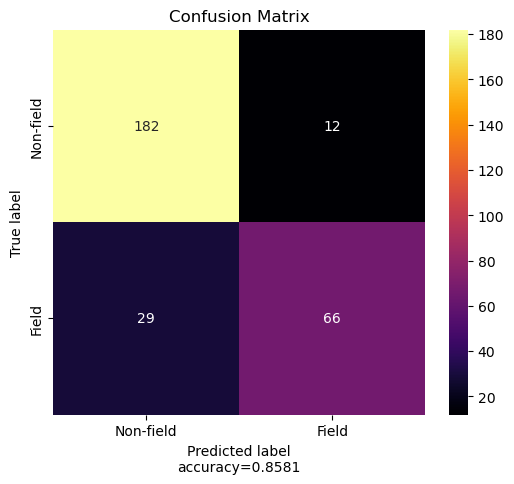

In [31]:
# Your confusion matrix and class names
cm = np.array(conf_matrix_values)
class_names = ['Non-field', 'Field'] 

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='inferno',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.ylabel('True label')
plt.xlabel(f'Predicted label\naccuracy={overall_accuracy:.4f}')
plt.title('Confusion Matrix')

# Save Conf Matrix
plt.savefig('/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/exports/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

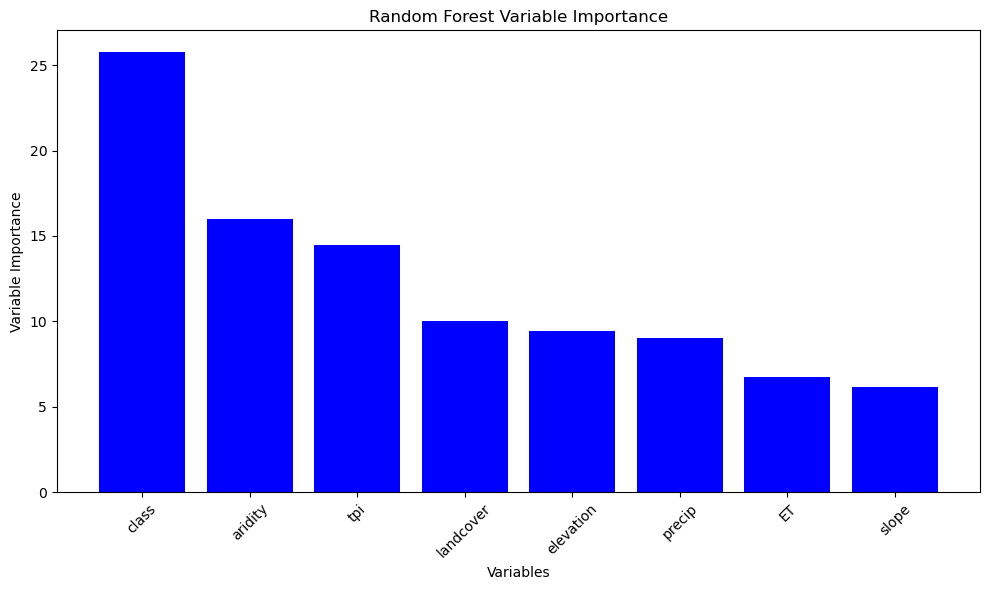

In [32]:
explanation = ee_classifier.explain()
importance = explanation.get('importance').getInfo()  # This is now a Python dict

# Sort by importance descending
sorted_items = sorted(importance.items(), key=lambda x: x[1], reverse=True)
variables, importances = zip(*sorted_items)

plt.figure(figsize=(10, 6))
plt.bar(variables, importances, color='blue')
plt.ylabel('Variable Importance')
plt.xlabel('Variables')
plt.title('Random Forest Variable Importance')
plt.xticks(rotation=45)
plt.tight_layout()

# Save Plot
plt.savefig('/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/exports/variable_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### Predict Test Tile with RF Model

In [39]:
classifier_asset = 'projects/angola-thesis/assets/Predictions/crop_classifier_test_07'
rf_classifier = ee.Classifier.load(classifier_asset)
tile_ids = [878593, 878594, 878613, 878614]

for tile_id in tile_ids:
    selected_tile = tiles.filter(ee.Filter.eq('tile', tile_id))
    prediction = full_stack_10m.select(important_bands) \
                              .clip(selected_tile.geometry()) \
                              .reproject('EPSG:32733', scale=10) \
                              .classify(rf_classifier)
    # Export to EE Asset
    task_asset = ee.batch.Export.image.toAsset(
        image=prediction,
        description=f'Prediction_{tile_id}_Asset',
        assetId=f'projects/angola-thesis/assets/Predictions/tile_{tile_id}',
        region=selected_tile.geometry(),
        scale=10,
        crs='EPSG:32733',
        maxPixels=1e13
    )
    task_asset.start()
    print(f"Asset export started for tile {tile_id}.")

Asset export started for tile 878593.
Asset export started for tile 878594.
Asset export started for tile 878613.
Asset export started for tile 878614.


#### Visualize Test Prediction

In [33]:
# Initialize the map
Map = geemap.Map()

# Loop over all tile IDs and add each as a layer
for tile_id in tile_ids:
    prediction_asset = f'projects/angola-thesis/assets/Predictions/tile_{tile_id}'
    prediction_img = ee.Image(prediction_asset)
    Map.addLayer(prediction_img, {'min': 0, 'max': 1, 'palette': ['red', 'green']}, f'Tile {tile_id}')

# Optionally center the map on the first tile
selected_tile = tiles.filter(ee.Filter.eq('tile', tile_ids[0]))
Map.centerObject(selected_tile.geometry(), 12)

#Display all predictor Variables
#for band in band_order:
    #Map.addLayer(full_stack_10m.select(band).mask(), {'min': 0, 'max': 1, 'palette': ['black', 'white']}, f'{band} mask')

Map

Map(center=[-15.134998672710392, 12.234000815782663], controls=(WidgetControl(options=['position', 'transparen…

#### Export Prediction from GEE to Drive

In [40]:
no_data_val = -9999

for tile_id in tile_ids:
    selected_tile = tiles.filter(ee.Filter.eq('tile', tile_id))
    # Recompute prediction for Drive export (critical!)
    prediction = full_stack_10m.select(important_bands) \
                              .clip(selected_tile.geometry()) \
                              .reproject('EPSG:32733', scale=10) \
                              .classify(rf_classifier)
    prediction_unmasked = prediction.unmask(no_data_val).toFloat()
    
    # Export to Google Drive
    task_drive = ee.batch.Export.image.toDrive(
        image=prediction_unmasked,
        description=f'Prediction_{tile_id}_Drive',
        folder='GEE_Exports',
        fileNamePrefix=f'prediction_tile_{tile_id}',
        region=selected_tile.geometry(),
        scale=10,
        crs='EPSG:32733',
        maxPixels=1e13,
        fileFormat='GeoTIFF',
        formatOptions={'noData': no_data_val}
    )
    task_drive.start()
    print(f"Drive export started for tile {tile_id}.")

Drive export started for tile 878593.
Drive export started for tile 878594.
Drive export started for tile 878613.
Drive export started for tile 878614.
